<a href="https://colab.research.google.com/github/ehabsameh/Labor_Force_Data/blob/main/Labor_force_participation_rate_by_state_vs_political_affiliation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Variable Explination:

The additional variables we selected from the census data set are Employment status for district populations for those over the age of 16 total, total not in labor force, and total in labor force. 

It is important to note that the labor force is made up of those who are either employed or unemployed. With actively employed persons being in the employed category and those who are actively seeking work in the unemployed category. Those who fall under neither category are considered not in the labor force. 

#Hypothesis

According to the bureau of labor statistics those who fall in the category of not in the labor force are typically either in school, retired, or have family responsibilities such as caring for a sick family member. We hypothesize that these groups are all more likely to support democratic congressional candidates. We believe college students are more likely to support democratic candidates due to social believes and potential student loan payouts, retired persons are more likely to support democratic candidates as they typically support medicare and medicaid programs that will benefit the elderly, and those caring for the sick are more likely to support democratic candidates due to their support of healthcare programs.  

#Data collection and Wrangling

            
### Our variables:
B23025_001E: EMPLOYMENT STATUS FOR THE POPULATION 16 YEARS AND OVER \
            Estimate!!Total: \
B23025_007E: EMPLOYMENT STATUS FOR THE POPULATION 16 YEARS AND OVER \
            Estimate!!Total:!!Not in labor force \
B23025_002E: EMPLOYMENT STATUS FOR THE POPULATION 16 YEARS AND OVER \
            Estimate!!Total:!!In labor force 

In [2]:
#import needed packages

import pandas as pd
import json
from urllib.request import urlopen
import matplotlib.pyplot as plt
import plotly.express as px
from urllib import request
import json
import numpy as np

In [3]:
url="https://api.census.gov/data/2021/acs/acs1?get=NAME,B23025_001E,B23025_007E,B23025_002E&for=congressional%20district:*&in=state:*"
response = urlopen(url)
data_json = json.loads(response.read())
data_json.pop(0)
cols = ['District Name','Total Households','Not in labor force', 'In labor force', 'State code', 'district number']
acs_df = pd.DataFrame(data_json, columns = cols)
acs_df[['District', 'State']] = acs_df['District Name'].str.split(',', expand=True)
acs_df['district number'] = pd.to_numeric(acs_df['district number'])
acs_df['State'] = acs_df['State'].str.strip()
acs_df = acs_df[['Total Households', 'Not in labor force', 'In labor force', 'district number', 'State']]
acs_df.head()

,Total Households,Not in labor force,In labor force,district number,State
0,589171,225060,364111,10,Michigan
1,624753,265753,359000,4,Mississippi
2,541190,215463,325727,14,Michigan
3,595469,270347,325122,1,Michigan
4,591680,254348,337332,3,Mississippi


In [4]:
# Convert the number columns into number data types so we can math on them
acs_df["Total Households"] = pd.to_numeric(acs_df["Total Households"])
acs_df["Not in labor force"] = pd.to_numeric(acs_df["Not in labor force"])
acs_df['In labor force'] = pd.to_numeric(acs_df['In labor force'])

acs_df['% of households not in labor force'] = (100*acs_df['Not in labor force'])/acs_df['Total Households']
acs_df['% of households in labor force'] = (100*acs_df['In labor force'])/acs_df['Total Households']
acs_df.head()

,Total Households,Not in labor force,In labor force,district number,State,% of households not in labor force,% of households in labor force
0,589171,225060,364111,10,Michigan,38.199436,61.800564
1,624753,265753,359000,4,Mississippi,42.537291,57.462709
2,541190,215463,325727,14,Michigan,39.812820,60.187180
3,595469,270347,325122,1,Michigan,45.400684,54.599316
4,591680,254348,337332,3,Mississippi,42.987426,57.012574


### Party affiliation data

In [5]:
# read from the congressional data and put into a pandas dataframe
party_df = pd.read_csv("http://goodcsv.com/wp-content/uploads/2020/08/us-house-of-representatives-2020.csv", encoding = "ISO-8859-1")

# extract the district number from the data (it was in the format of 5th and we want that to just be 5) using a regular expression.
party_df['district number'] = party_df['District/Position'].str.extract('(\d+)')
party_df['district number'] = party_df['district number'].fillna(0)
party_df['district number'] = pd.to_numeric(party_df['district number'])
party_df['State'] = party_df['State/Territory']
party_df['State'] = party_df['State'].str.strip()
party_df['Party'] = party_df['Party'].str.strip() # remove extraneous whitespace

# Let's just keep the columns we need
party_df = party_df[['State', 'Party', "district number"]]

party_df.head(5)

,State,Party,district number
0,Louisiana,R,5
1,North Carolina,D,12
2,Alabama,R,4
3,California,D,31
4,Georgia,R,12


In [6]:
party_df['State'].value_counts()

California                  53
Texas                       36
New York                    27
Florida                     27
Pennsylvania                18
Illinois                    18
Ohio                        16
Michigan                    14
Georgia                     14
North Carolina              13
New Jersey                  12
Virginia                    11
Washington                  10
Indiana                      9
Arizona                      9
Tennessee                    9
Massachusetts                9
Minnesota                    8
Missouri                     8
Maryland                     8
Wisconsin                    8
Colorado                     7
Alabama                      7
South Carolina               7
Louisiana                    6
Kentucky                     6
Oklahoma                     5
Oregon                       5
Connecticut                  5
Nevada                       4
Kansas                       4
Arkansas                     4
Iowa    

In [7]:
acs_df['State'].value_counts()

California              53
Texas                   36
Florida                 27
New York                27
Illinois                18
Pennsylvania            18
Ohio                    16
Georgia                 14
Michigan                14
North Carolina          13
New Jersey              12
Virginia                11
Washington              10
Indiana                  9
Massachusetts            9
Arizona                  9
Tennessee                9
Missouri                 8
Wisconsin                8
Minnesota                8
Maryland                 8
South Carolina           7
Alabama                  7
Colorado                 7
Kentucky                 6
Louisiana                6
Connecticut              5
Oklahoma                 5
Oregon                   5
Iowa                     4
Kansas                   4
Arkansas                 4
Mississippi              4
Nevada                   4
Utah                     4
New Mexico               3
West Virginia            3
N

These match, so okay to join on states...

### Merge Party affiliation and labor Force data
Merge on State and District number

In [8]:
merged_df = pd.merge(acs_df, party_df, on=["State", "district number"])
merged_df['Party'].value_counts()

D    233
R    201
L      1
Name: Party, dtype: int64

In [9]:
merged_df.head()

,Total Households,Not in labor force,In labor force,district number,State,% of households not in labor force,% of households in labor force,Party
0,589171,225060,364111,10,Michigan,38.199436,61.800564,R
1,624753,265753,359000,4,Mississippi,42.537291,57.462709,R
2,541190,215463,325727,14,Michigan,39.812820,60.187180,D
3,595469,270347,325122,1,Michigan,45.400684,54.599316,R
4,591680,254348,337332,3,Mississippi,42.987426,57.012574,R


### Aggregate on state level

In [10]:
state_level = merged_df.groupby(by = "State")["% of households not in labor force"].mean()
len(state_level.index)

# state Level aggregation on the raw variables



50

In [11]:
state_level

State
Alabama           42.340461
Alaska            34.077666
Arizona           39.377513
Arkansas          41.729490
California        36.696296
Colorado          32.021628
Connecticut       34.371864
Delaware          39.943747
Florida           40.687082
Georgia           37.270981
Hawaii            36.615085
Idaho             36.722103
Illinois          35.572648
Indiana           36.607735
Iowa              33.977007
Kansas            34.420930
Kentucky          41.450213
Louisiana         41.660214
Maine             38.772835
Maryland          33.494109
Massachusetts     33.290860
Michigan          39.203448
Minnesota         31.722465
Mississippi       43.494432
Missouri          37.296525
Montana           38.155507
Nebraska          31.551366
Nevada            37.176761
New Hampshire     33.376306
New Jersey        34.393660
New Mexico        43.104729
New York          37.502106
North Carolina    38.028973
North Dakota      31.914611
Ohio              37.471400
Oklahoma      

In [12]:
max(state_level)

47.550614129074184

In [13]:
#next merge with DF

#Analysis and Hypothesis Testing

## Party Affiliation Map

In [14]:
#abreviations for state names
us_state_to_abbrev = {
    "Alabama": "AL",
    "Alaska": "AK",
    "Arizona": "AZ",
    "Arkansas": "AR",
    "California": "CA",
    "Colorado": "CO",
    "Connecticut": "CT",
    "Delaware": "DE",
    "Florida": "FL",
    "Georgia": "GA",
    "Hawaii": "HI",
    "Idaho": "ID",
    "Illinois": "IL",
    "Indiana": "IN",
    "Iowa": "IA",
    "Kansas": "KS",
    "Kentucky": "KY",
    "Louisiana": "LA",
    "Maine": "ME",
    "Maryland": "MD",
    "Massachusetts": "MA",
    "Michigan": "MI",
    "Minnesota": "MN",
    "Mississippi": "MS",
    "Missouri": "MO",
    "Montana": "MT",
    "Nebraska": "NE",
    "Nevada": "NV",
    "New Hampshire": "NH",
    "New Jersey": "NJ",
    "New Mexico": "NM",
    "New York": "NY",
    "North Carolina": "NC",
    "North Dakota": "ND",
    "Ohio": "OH",
    "Oklahoma": "OK",
    "Oregon": "OR",
    "Pennsylvania": "PA",
    "Rhode Island": "RI",
    "South Carolina": "SC",
    "South Dakota": "SD",
    "Tennessee": "TN",
    "Texas": "TX",
    "Utah": "UT",
    "Vermont": "VT",
    "Virginia": "VA",
    "Washington": "WA",
    "West Virginia": "WV",
    "Wisconsin": "WI",
    "Wyoming": "WY",
    "District of Columbia": "DC",
    "American Samoa": "AS",
    "Guam": "GU",
    "Northern Mariana Islands": "MP",
    "Puerto Rico": "PR",
    "United States Minor Outlying Islands": "UM",
    "U.S. Virgin Islands": "VI",
}

In [15]:

# State Level data frame

df_state_1 = pd.pivot_table(merged_df, index="State", values=(['Total Households', 'Not in labor force', 'In labor force']),aggfunc=sum)

df_state_2 = pd.pivot_table(merged_df, index="State", columns = (['Party']),aggfunc='count')
df_state_2 = df_state_2[['Total Households', 'Not in labor force']]
df_state_2.columns = df_state_2.columns.map('_'.join)
col = df_state_2.columns
df_state_2[col] = df_state_2[col].apply(pd.to_numeric, errors='coerce')
df_state_2 = df_state_2.fillna(0)
df_state_2['R_Ratio'] = df_state_2['Total Households_R']/(df_state_2['Total Households_D']+df_state_2['Total Households_L']+df_state_2['Total Households_R'])
df_state_2 = df_state_2[['R_Ratio']]

df_state = pd.merge(df_state_1, df_state_2, on=["State"])
df_state['Not in Labor Force Rate']= (100*df_state['Not in labor force']/df_state['Total Households'])
df_state.reset_index(inplace=True)

## New State Level Geo Map

df_state['State_Code'] = df_state.State.map(us_state_to_abbrev)

fig_e1 = px.choropleth(df_state, locations='State_Code', locationmode="USA-states", scope="usa", color='Not in Labor Force Rate',color_continuous_scale="viridis")
fig_e1.show()





In [16]:
##  State Level Political sub Geo Map

df_state['State_Code'] = df_state.State.map(us_state_to_abbrev)
df_state['Party'] = np.where(df_state['R_Ratio']>= 0.5, 'Republican Majority', 'Democratic Majorty')

fig_e3 = px.choropleth(df_state, locations='State_Code', locationmode="USA-states", scope="usa", color='Not in Labor Force Rate',color_continuous_scale="viridis", facet_col="Party" )
fig_e3.show()



##Party Affiliation Dominance Ratio
- To better assess how the "Not in Labor Force Rate" would impact/reflect the political affiliation we categorize the US states political affiliation based on more griadient political affiliation variable with One (Solid Red) represending states with 100% of the congressional districts dominated by Republicans and and Zero being the states with 100% democrares domination.

- The plot provide didn't provide support for our original hypothesis where the Red/Republican dominant states are having relatively higher values of "% of Household Not in Labor Force", compared to the Blue/Democratic demonant states



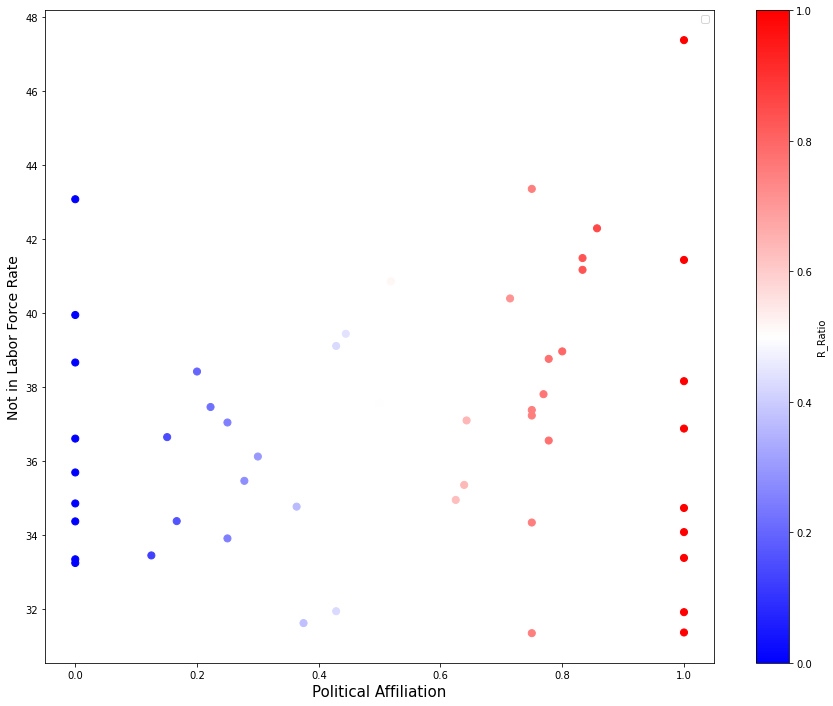

In [17]:
## Democratic districts ratio vs Not in Labor Force Rate

#s1= df_state['Total Households']/30000
fig_e2, ax = plt.subplots(figsize=(15, 12))
df_state.plot.scatter(x='R_Ratio', y='Not in Labor Force Rate', c='R_Ratio',s=50, colormap='bwr', ax=ax)
plt.ylabel("Not in Labor Force Rate", fontsize=14)
plt.xlabel("Political Affiliation", fontsize=15)
plt.legend()
plt.show()

#Take Aways - Flaws